In [79]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import pydicom as dicom
from PIL import Image

In [80]:
train_image_path = '../datasets/lidc-idri/images/train/'
train_label_path = '../datasets/lidc-idri/labels/train/'

test_image_path = '../datasets/lidc-idri/images/test/'
test_label_path = '../datasets/lidc-idri/labels/test/'

val_image_path = '../datasets/lidc-idri/images/val/'
val_label_path = '../datasets/lidc-idri/labels/val/'

aug_image_path = '../datasets/lidc-idri/images/augment/'
aug_label_path = '../datasets/lidc-idri/labels/augment/'

image_size = 512

In [81]:
def rotate90(image,x,y,w,h):
    new_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    new_x = y
    new_y = image_size - x
    new_w = h
    new_h = w
    return new_image, new_x, new_y, new_w, new_h

def rotate270(image,x,y,w,h):
    new_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    new_x = image_size - y
    new_y = x
    new_w = h
    new_h = w
    return new_image, new_x, new_y, new_w, new_h

def flip_horizontal(image,x,y,w,h):
    new_image = cv2.flip(image, 1)
    new_x = image_size - x
    new_y = y
    return new_image, new_x, new_y, w, h

def flip_vertical(image,x,y,w,h):
    new_image = cv2.flip(image, 0)
    new_x = x
    new_y = image_size - y
    return new_image, new_x, new_y, w, h

def flip_both(image,x,y,w,h):
    h_image, h_x, h_y,_,_ = flip_horizontal(image,x,y,w,h)
    flipped_image, flipped_x, flipped_y,_,_ = flip_vertical(h_image, h_x, h_y,w,h)
    return flipped_image, flipped_x, flipped_y, w, h

def augment(image, labels):
    x = labels[:,1]
    y = labels[:,2]
    w = labels[:,3]
    h = labels[:,4]
    
    x*=image_size
    y*=image_size
    
    choice = random.randint(0,4)

    if (choice == 0):
           res_image, res_x, res_y, res_w, res_h = rotate90(image,x,y,w,h)
    elif (choice == 1):
            res_image, res_x, res_y, res_w, res_h = rotate270(image,x,y,w,h)
    elif (choice == 2):
            res_image, res_x, res_y, res_w, res_h = flip_horizontal(image,x,y,w,h)
    elif (choice == 3):
            res_image, res_x, res_y, res_w, res_h = flip_vertical(image,x,y,w,h)
    elif (choice == 4):
            res_image, res_x, res_y, res_w, res_h = flip_both(image,x,y,w,h)
    
    res_x/= image_size
    res_y/= image_size
    res_labels = [[res_x[i], res_y[i], res_w[i], res_h[i]] for i in range(len(res_x))]       
    return res_image, res_labels

In [83]:
# Initiate augmentation process
expected_total_train_data = 4000

train_image_item = os.listdir(train_image_path)
train_label_item = os.listdir(train_label_path)
train_item_count = len(train_image_item)
pointer = 0

while (train_item_count < expected_total_train_data):
    filename = train_image_item[pointer].split('.')[0]
    image = cv2.imread(os.path.join(train_image_path, train_image_item[pointer]))
    with open(train_label_path + train_label_item[pointer], 'r') as f:
        labels = [label.strip() for label in f.readlines()]
        f.close()
    
    splitted_labels = np.array([label.split(' ') for label in labels]).astype(float)
    aug_image, aug_labels = augment(image,splitted_labels)
    
    
    res_image = Image.fromarray(aug_image)
    res_image.save(aug_image_path + filename + '-1.png')
    
    with open(aug_label_path + filename + '-1.txt', 'a') as f:
        for label in aug_labels:
            f.write('0 '+ str(label[0]) + ' ' + str(label[1]) 
                    + ' ' + str(label[2]) + ' ' + str(label[3]) + '\n')
        f.close()
    
    train_item_count = train_item_count + 1   
    pointer = pointer + 1 

In [46]:
#Preview Annotation

image_path = aug_image_path
label_path = aug_label_path

image_item = os.listdir(image_path)
label_item = os.listdir(label_path)
filename = label_item[100].split('.')[0]

with open(label_path + filename+'.txt', 'r') as f:
        labels = [label.strip() for label in f.readlines()]
        f.close()

splitted_labels = np.array([label.split(' ') for label in labels]).astype(float)
x = splitted_labels[:,1]
y = splitted_labels[:,2]
w = splitted_labels[:,3]
h = splitted_labels[:,4]

x*= image_size
y*= image_size
w*= image_size
h*= image_size

x1 = x - w/2
x2 = x + w/2
y1 = y - h/2
y2 = y + h/2

image = cv2.imread(os.path.join(image_path, filename+'.png'))

for x_i,y_i, x2_i, y2_i in zip(x1,y1,x2,y2):
        start_point = (int(x_i),int(y_i))
        end_point = (int(x2_i),int(y2_i))
        cv2.rectangle(image, start_point , end_point, (0,255,0), 1)
cv2.imshow('Annotated', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [74]:
splitted_labels

array([[  0.        , 512.        , 143.07610619, 346.39469027,
         33.        ]])

In [70]:
import pylidc as pl

data = pl.query(pl.Scan).first()
images = data.load_all_dicom_images()
image = np.array(images[30].pixel_array)

Loading dicom files ... This may take a moment.


In [71]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [72]:
dicom_dirpath = data.get_path_to_dicom_files()
dicom_path = os.path.join(dicom_dirpath, os.listdir(dicom_dirpath)[0])
dicom_image = dicom.read_file(dicom_path)

rescale_slope = dicom_image.RescaleSlope
rescale_intercept = dicom_image.RescaleIntercept
window_centers = dicom_image.WindowCenter
window_widths = dicom_image.WindowWidth


hu_image = transform_to_hu(dicom_image, image)
hu_image[image < -1000] = -1000
hu_image[image > 400] = 400

windowed_image = window_image(hu_image, window_centers, window_widths)

min_value = windowed_image.min()
max_value = windowed_image.max()
displayed_img = ((windowed_image - min_value) * (255 / (max_value - min_value))).astype(np.uint8)


In [73]:
displayed_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

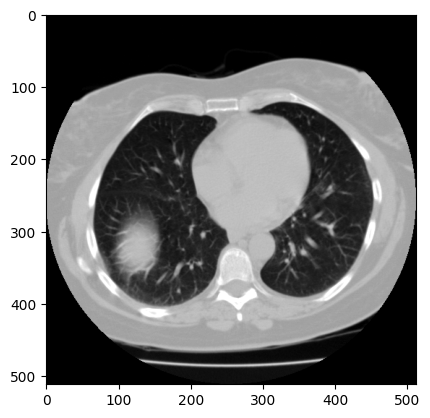

In [75]:
plt.imshow(displayed_img, cmap=mpl.colormaps['gray'])
plt.show()

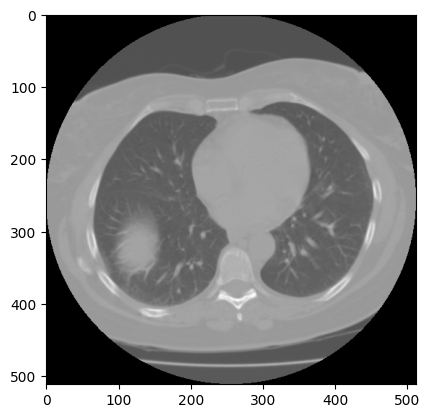

In [76]:
plt.imshow(image, cmap=mpl.colormaps['gray'])
plt.show()

In [78]:
vol_array = data.to_volume()
vol_array

Loading dicom files ... This may take a moment.


array([[[-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048]],

       [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048]],

       [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        ...,
        [-2048, -2048, -2048, ..., -2048, -2048, -2048],
        [-2048, -2048, -2048, ..., -2048, -20